In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import meals
from foods.dashboard import (
    read_database,
    find_item, 
    make_data, meal_plots,
    nuts_plots,
    staple_plots
)

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

foods = read_database()

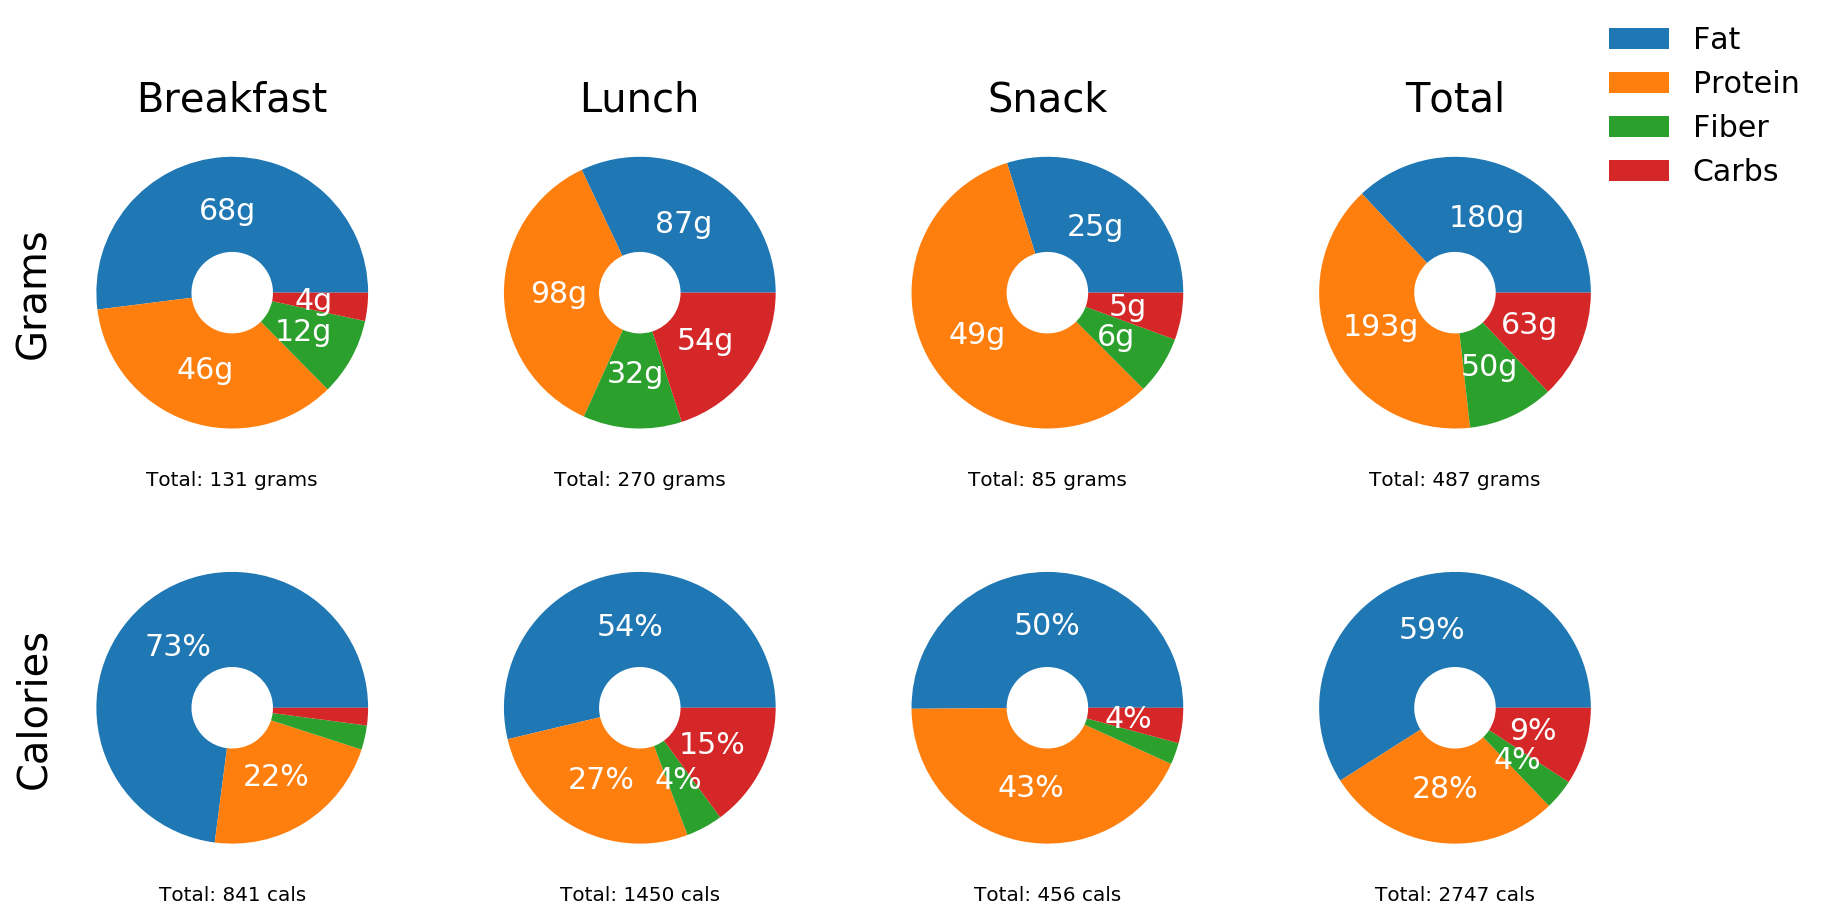

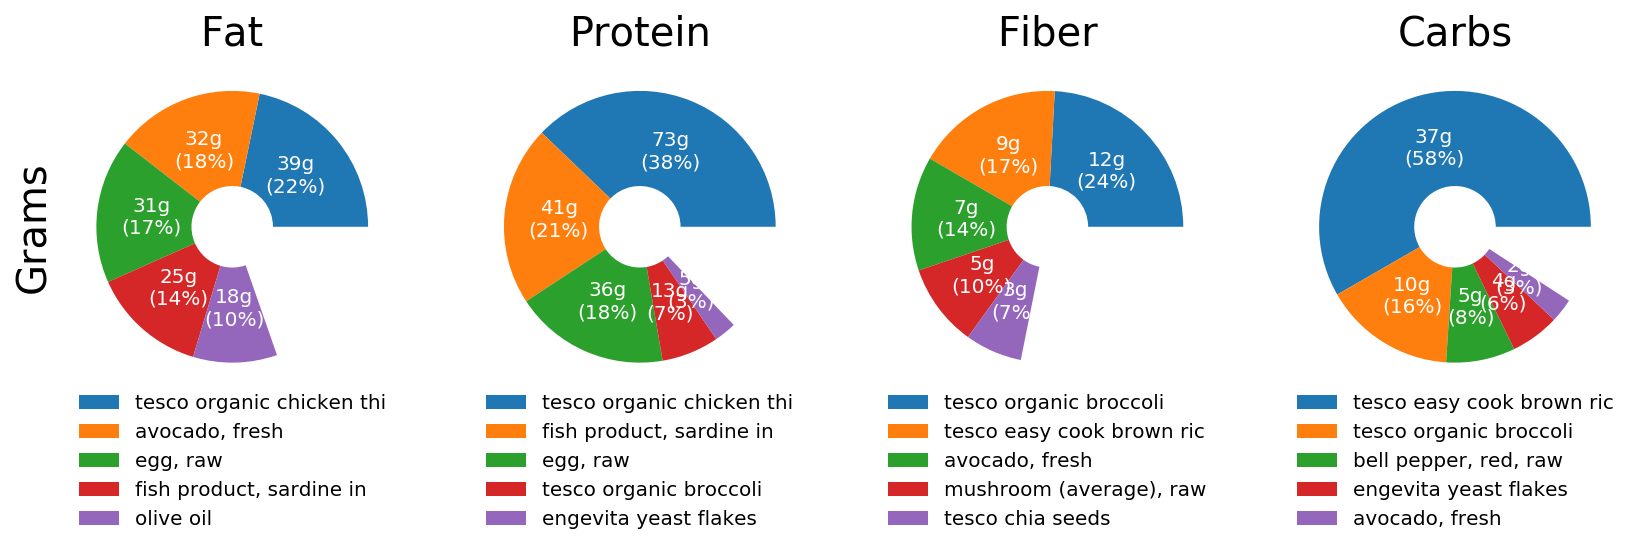

In [12]:
meal_data = make_data(meals.may13_2021, foods)
meal_plots(meal_data)
nuts_plots(meal_data)

# Staple nutrients

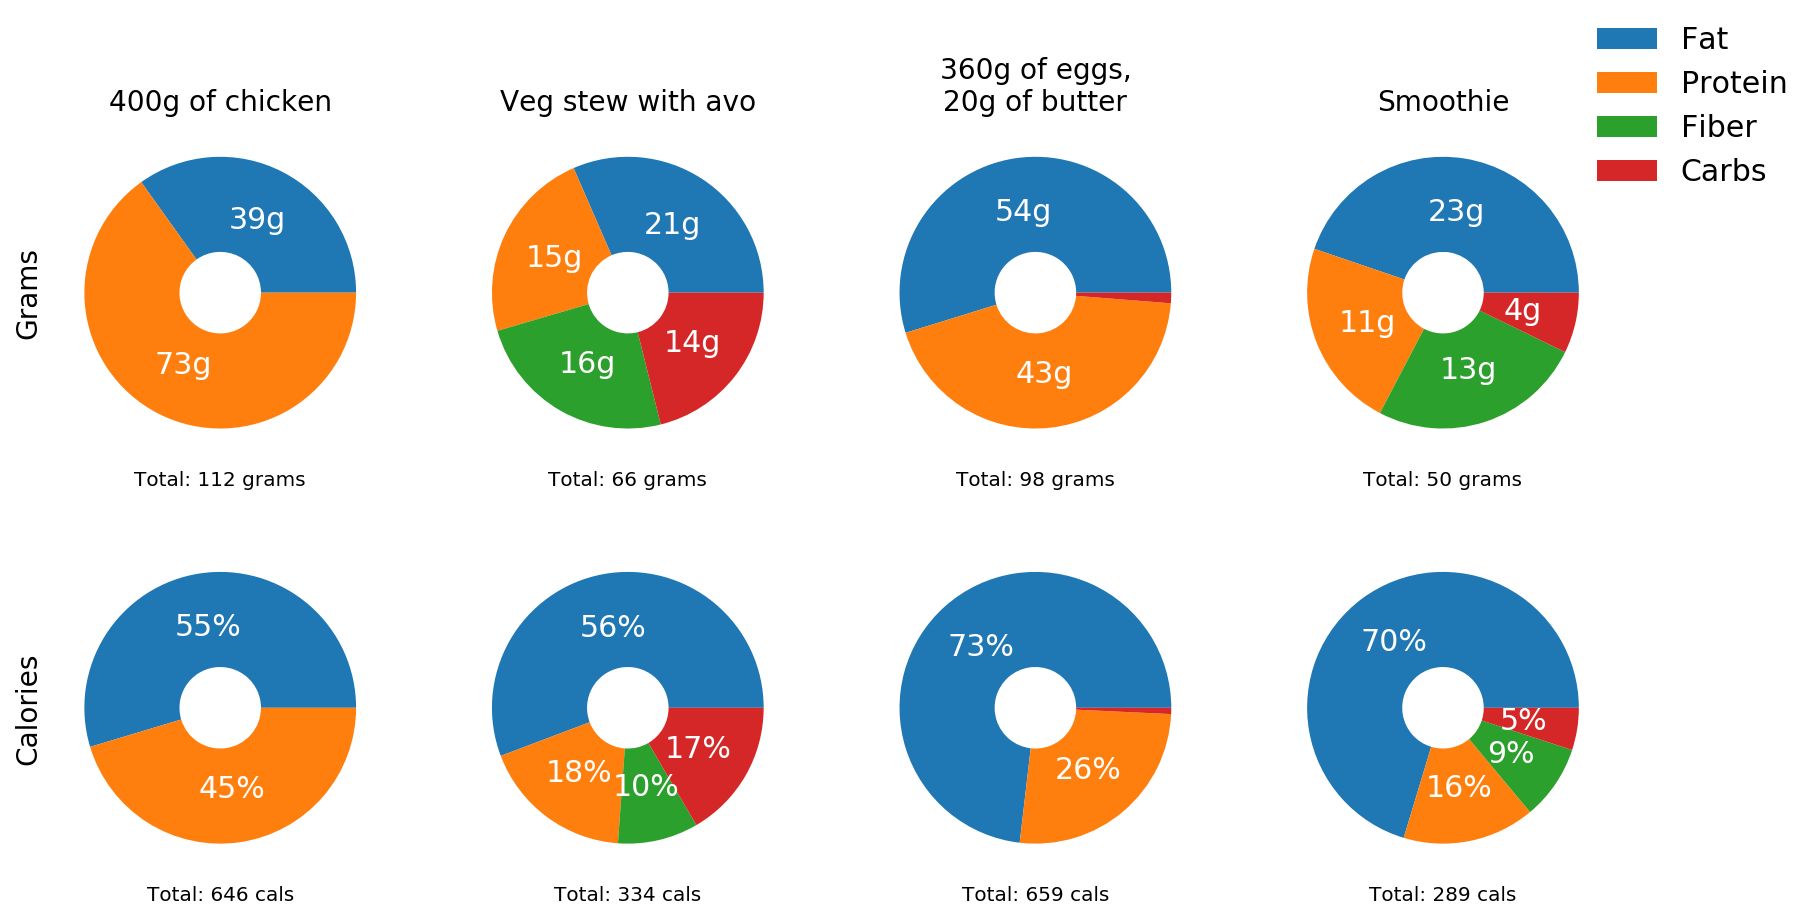

In [15]:
import meals
foods = read_database()
meal_data = make_data(meals.staples1, foods)
staple_plots(meal_data)

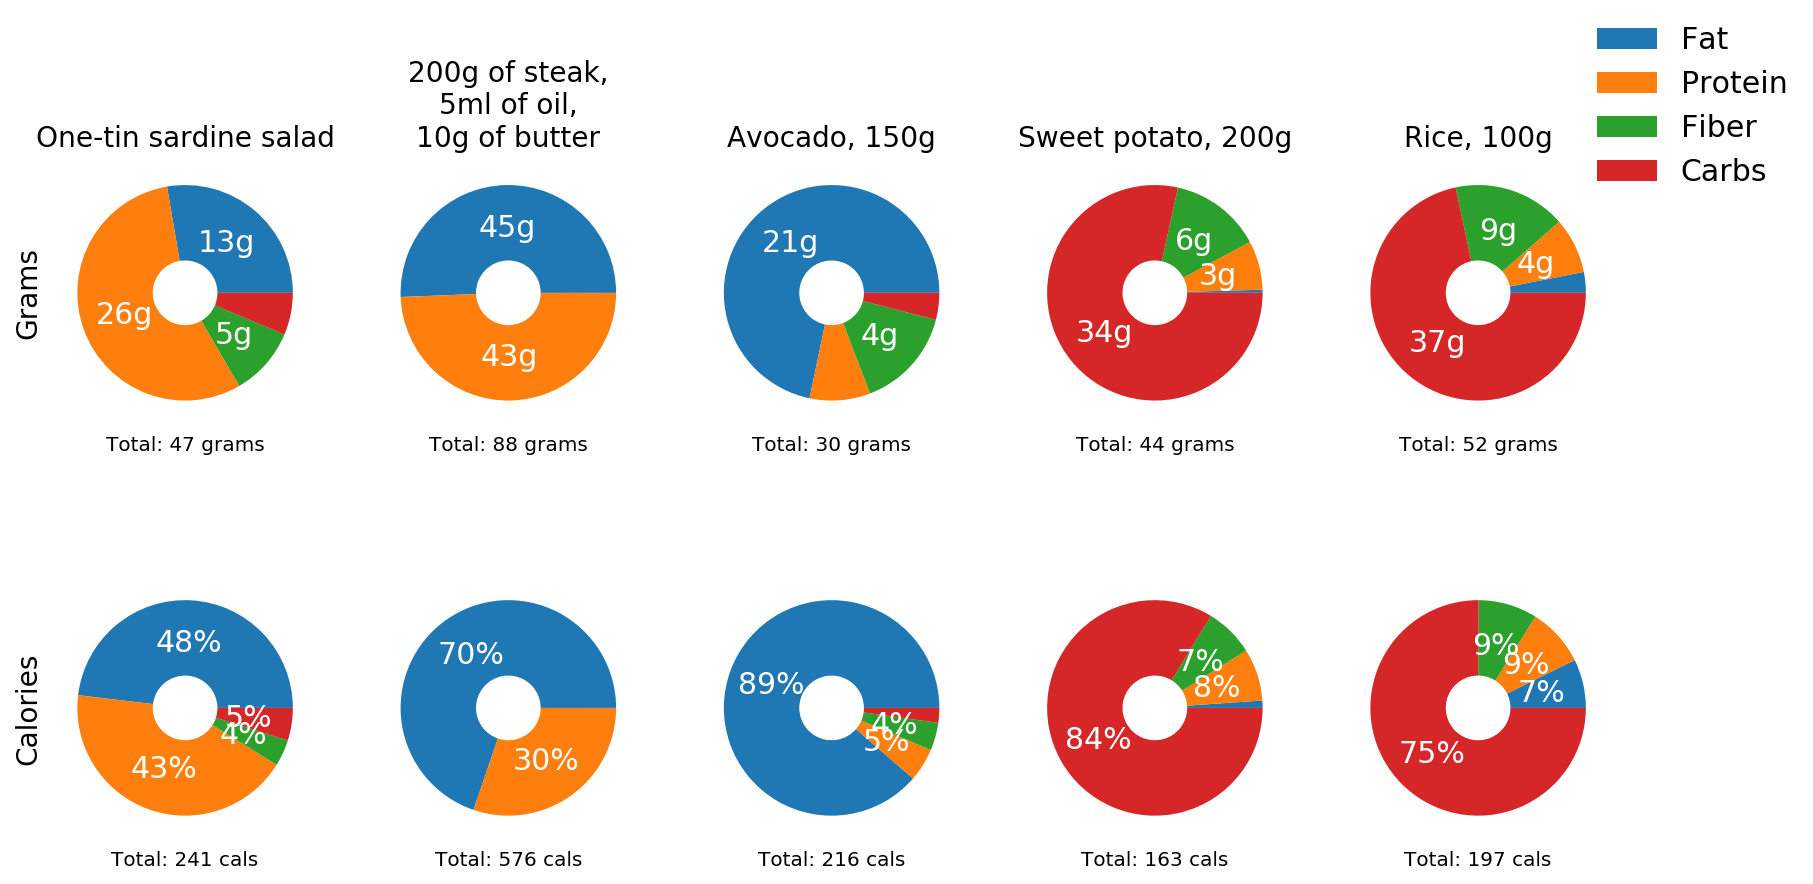

In [21]:
import meals
foods = read_database()
meal_data = make_data(meals.staples2, foods)
staple_plots(meal_data)

## Foods finder

In [36]:
find_item('choi', foods)

,ingredient,category,fat,carbs,sugar,fiber,protein
142,butter of choice,fats and oils/fats;milk and dairy products/cre...,82.3,0.7,0.6,0.0,0.7
